In [1]:
library(tidyverse)
library(httr)
library(jsonlite)
library(data.table)
library(ggplot2)
library(dplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [2]:
get_odata_catalogue <-  function(service, endpoint, service_api_key) {
  
  catalogue_url <- URLencode(paste0(service, "/", endpoint))
  
  # Add the proxy authentication
  config_proxy <- use_proxy(
    url = curl::ie_get_proxy_for_url(service), 
    auth = "any", 
    username = ""
  )
  
  # Look at the available tables
  opendata_catalogue <- 
    GET(
      url = catalogue_url,
      config_proxy,
      add_headers(.headers = c('Cache-Control' = 'no-cache',
                               'Ocp-Apim-Subscription-Key' = service_api_key)),
      timeout(60)
    ) %>%
    content(as = "text") %>%
    fromJSON()
  
  opendata_catalogue <- as.data.frame(opendata_catalogue$dataset) %>%
    unnest_longer(distribution)
  
  
  structure(opendata_catalogue,
            comment = "Odata Catalogue")
  
}

In [3]:
Catalogue <- get_odata_catalogue( # funtion to access API
  service="https://api.stats.govt.nz/opendata/v1", # API web access point
  endpoint="data.json",  # Get all resources for the data.json endpoint
  service_api_key = "b64ff0071dc049ab8891f64057d33859" # key for access this API
)
Catalogue %>% typeof()
Catalogue %>% glimpse() # a brief view of the content

[1] "list"

Rows: 4
Columns: 16
$ title              <chr> "Employment Indicators", "Overseas Cargo", "Covid19…
$ description        <chr> "This employment indicator series is intended to pr…
$ identifier         <chr> "https://api.stats.govt.nz/odata/v1/EmploymentIndic…
$ license            <chr> "https://creativecommons.org/licenses/by/4.0/", "ht…
$ keyword            <list> <"Employment", "ResourceID MEI1.1: Filled jobs and…
$ issued             <chr> "2020-08-11T19:45:06Z", "2020-08-06T23:31:28Z", "20…
$ modified           <chr> "2020-12-10T22:39:15Z", "2020-12-10T22:51:17Z", "20…
$ publisher          <df[,2]> <data.frame[4 x 2]>
$ contactPoint       <df[,3]> <data.frame[4 x 3]>
$ landingPage        <chr> "https://www.stats.govt.nz", "https://www.stats.…
$ language           <list> "en", "en", "en", "en"
$ accrualPeriodicity <chr> "Monthly", "Monthly", "Weekly", "Monthly"
$ theme              <chr> "Employment", "Commerce, trade and industry", ""…
$ temporal           <chr> "1999-04-30/", "198

In [4]:
Catalogue$title %>% as.factor() %>% levels() 
Catalogue$identifier %>% as.factor() %>% levels()

[1] "Covid19 Indicators"      "Employment Indicators"  
[3] "International Migration" "Overseas Cargo"

[1] "https://api.stats.govt.nz/odata/v1/Covid-19Indicators"    
[2] "https://api.stats.govt.nz/odata/v1/EmploymentIndicators"  
[3] "https://api.stats.govt.nz/odata/v1/InternationalMigration"
[4] "https://api.stats.govt.nz/odata/v1/OverseasCargo"

In [5]:
get_odata <-  function(service, endpoint, entity, query_option, service_api_key) {
  
  config_proxy <- use_proxy(
    url = curl::ie_get_proxy_for_url(service),
    auth = "any",
    username = ""
  )
  
  odata_url <- URLencode(paste0(service, "/", endpoint, "/", entity, "?", query_option))
  top_query <- grepl("$top",query_option,fixed=TRUE)
  
  # continue getting results while there are additional pages
  
  while (!is.null(odata_url)) {
    
    result <- GET(odata_url,
                  config_proxy,
                  add_headers(.headers = c("Content-Type" = "application/json;charset=UTF-8",
                                           "Ocp-Apim-Subscription-Key" = service_api_key)),
                  timeout(60)
    )
    
    
    # catch errors
    
    if (http_type(result) != "application/json") {
      stop("API did not return json", call. = FALSE)
    }
    
    
    if (http_error(result)) {
      stop(
        sprintf(
          "The request failed - %s \n%s \n%s ",
          http_status(result)$message,
          fromJSON(content(result, "text"))$value,
          odata_url
        ),
        call. = FALSE
      )
    }
    
    
    # parse and concatenate result while retaining UTF-8 encoded characters
    
    parsed <- jsonlite::fromJSON(content(result, "text", encoding = "UTF-8"), flatten = TRUE)
    response  <- rbind(parsed$value, if(exists("response")) response)
    odata_url <- parsed$'@odata.nextLink'
    
    
    cat("\r", nrow(response), "obs retrieved")
    
    # break when top(n) obs are specified
    
    if (top_query) {
      break
    }
    
  }
  
  structure(response,
            comment = "Odata response")
  
}

In [69]:
startday <- as.Date("2018-01-01")
endday <- as.Date("2021-09-30")

In [7]:
# We use CPACT12 NZAC as a indicator of part of our research resources
NZAC <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1", 
                           endpoint = "Covid-19Indicators",  # get data in Covid-19 Indicators
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT12')",# CPACT12 New Zealand Activity Index (NZAC)   
                           service_api_key = "b64ff0071dc049ab8891f64057d33859"))

NZAC$Period <- as.Date(NZAC$Period,"%Y-%m-%d") # convert char to date type
NZAC <- NZAC[which(NZAC$Period >= startday & NZAC$Period < endday),] # filter which period of data we need
colnames(NZAC)[which(colnames(NZAC) == 'Label1')] <- 'Type' # rename the columns Label1 to Type
NZAC %>% glimpse() # Take a brief look of the data frame

# write_csv(NZAC,"NZAC.csv") # Save the data frame to csv file


 1501 obs retrievedRows: 308
Columns: 9
$ id         <chr> "5656e38e-2c4f-4fcc-ba88-8a038cc0fcce", "edae3b97-70ab-4735…
$ ResourceID <chr> "CPACT12", "CPACT12", "CPACT12", "CPACT12", "CPACT12", "CPA…
$ Period     <date> 2018-01-31, 2018-05-31, 2018-02-28, 2018-06-30, 2018-03-31…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Type       <chr> "New Zealand Activity Index (NZAC)", "New Zealand Activity …
$ Value      <dbl> 2.7837, 2.4996, 2.0162, 2.4732, 2.3251, 3.2071, 2.0675, 2.1…
$ Unit       <chr> "%", "%", "%", "%", "%", "%", "%", "%", "%", "%", "%", "%",…
$ Measure    <chr> "Annual percentage change", "Annual percentage change", "An…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [97]:
NZAC_Wide <- NZAC %>% select(Period, Type, Value) # select columns we need

# convert long data to wide data by reshape
NZAC_Wide <- reshape(NZAC_Wide, idvar="Period", timevar="Type", direction="wide",sep = " ") 

#rename all columns for better view and understand
NZAC_Wide %>% rename('combined_index'='Value New Zealand Activity Index (NZAC)', 'Card_trans_spend'='Value NZAC component - Card transaction spend',
                    'Electricity_grid_demand'='Value NZAC component - Electricity grid demand', 'Manufacturing_index'='Value NZAC component - Manufacturing index',
                    'New_jobs_posted'='Value NZAC component - New jobs posted online', 'Traffic_index_heavy'='Value NZAC component - Traffic index (heavy)',
                    'Traffic_index_light'='Value NZAC component - Traffic index (light)')

NZAC_Wide %>% glimpse() # Take a brief look of the data frame
write.csv(NZAC_Wide,"NZAC_Wide.csv") # save the data frame into CSV file for further use



# colnames(NZAC_Wide)[which(colnames(NZAC_Wide) == 'Value New Zealand Activity Index (NZAC)')] <- 'combined_index'
# colnames(NZAC_Wide)[which(colnames(NZAC_Wide) == 'Value NZAC component - Card transaction spend')] <- 'Card_trans_spend'
# colnames(NZAC_Wide)[which(colnames(NZAC_Wide) == 'Value NZAC component - Electricity grid demand')] <- 'Electricity_grid_demand'
# colnames(NZAC_Wide)[which(colnames(NZAC_Wide) == 'Value NZAC component - Manufacturing index')] <- 'Manufacturing_index'
# colnames(NZAC_Wide)[which(colnames(NZAC_Wide) == 'Value NZAC component - New jobs posted online')] <- 'New_jobs_posted'
# colnames(NZAC_Wide)[which(colnames(NZAC_Wide) == 'Value NZAC component - Traffic index (heavy)')] <- 'Traffic_index_heavy'
# colnames(NZAC_Wide)[which(colnames(NZAC_Wide) == 'Value NZAC component - Traffic index (light)')] <- 'Traffic_index_light'



,Period,combined_index,Card_trans_spend,Electricity_grid_demand,Manufacturing_index,New_jobs_posted,Traffic_index_heavy,Traffic_index_light
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
172,2018-01-31,2.7837,5.3782,1.3820,54.0703,7.8300,6.3679,4.0490
173,2018-05-31,2.4996,4.6429,-0.3676,55.9290,10.2977,4.0267,3.8703
174,2018-02-28,2.0162,4.7941,-2.5886,54.0006,6.9876,0.5741,3.9637
175,2018-06-30,2.4732,4.9796,3.1897,52.3188,5.3665,3.6684,2.9865
176,2018-03-31,2.3251,5.5985,-2.2209,54.5001,10.1138,2.6023,4.4959
177,2018-04-30,3.2071,3.5565,2.5937,58.9936,7.5861,4.8743,4.1611
178,2018-07-31,2.0675,4.9342,-0.0425,51.8858,6.1325,6.5096,2.6131
179,2018-08-31,2.1989,6.4009,1.2965,52.7673,5.6965,4.3570,3.9572
180,2018-10-31,2.3268,6.5914,2.1766,52.4004,7.6946,5.2491,1.1121


,Period,Value New Zealand Activity Index (NZAC),Value NZAC component - Card transaction spend,Value NZAC component - Electricity grid demand,Value NZAC component - Manufacturing index,Value NZAC component - New jobs posted online,Value NZAC component - Traffic index (heavy),Value NZAC component - Traffic index (light)
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
172,2018-01-31,2.7837,5.3782,1.3820,54.0703,7.8300,6.3679,4.0490
173,2018-05-31,2.4996,4.6429,-0.3676,55.9290,10.2977,4.0267,3.8703
174,2018-02-28,2.0162,4.7941,-2.5886,54.0006,6.9876,0.5741,3.9637
175,2018-06-30,2.4732,4.9796,3.1897,52.3188,5.3665,3.6684,2.9865
176,2018-03-31,2.3251,5.5985,-2.2209,54.5001,10.1138,2.6023,4.4959
177,2018-04-30,3.2071,3.5565,2.5937,58.9936,7.5861,4.8743,4.1611
178,2018-07-31,2.0675,4.9342,-0.0425,51.8858,6.1325,6.5096,2.6131
179,2018-08-31,2.1989,6.4009,1.2965,52.7673,5.6965,4.3570,3.9572
180,2018-10-31,2.3268,6.5914,2.1766,52.4004,7.6946,5.2491,1.1121


In [9]:
cpi <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPTRD3')",# CPBUS4  Enterprise counts by industry
                           service_api_key = "b64ff0071dc049ab8891f64057d33859"))

cpi$Period <- as.Date(cpi$Period,"%Y-%m-%d")
cpi <- cpi[which(cpi$Period >= startday & cpi$Period < endday),]
colnames(cpi)[which(colnames(cpi) == 'Label1')] <- 'Type'
cpi %>% glimpse()

# Commodity price index
# write_csv(cpi,"cpi.csv")

 3296 obs retrievedRows: 780
Columns: 9
$ id         <chr> "0f54f266-0e52-46df-87a2-7a8e8a504b49", "cb56236f-15dc-4cbc…
$ ResourceID <chr> "CPTRD3", "CPTRD3", "CPTRD3", "CPTRD3", "CPTRD3", "CPTRD3",…
$ Period     <date> 2018-01-05, 2018-01-12, 2018-01-19, 2018-02-02, 2018-01-26…
$ Duration   <chr> "P7D", "P7D", "P7D", "P7D", "P7D", "P7D", "P7D", "P7D", "P7…
$ Type       <chr> "Dairy", "Dairy", "Dairy", "Dairy", "Dairy", "Dairy", "Dair…
$ Value      <dbl> 92.3015, 91.7973, 94.8756, 96.5359, 94.7983, 99.7985, 100.8…
$ Unit       <chr> "Index", "Index", "Index", "Index", "Index", "Index", "Inde…
$ Measure    <chr> "ASB NZ Commodity prices Index (USD)", "ASB NZ Commodity pr…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [10]:
cpi_Wide <- cpi %>% select(Period, Type, Value)

cpi_Wide <- reshape(cpi_Wide, idvar="Period", timevar="Type", direction="wide",sep = " ")

cpi_Wide %>% glimpse()
# write.csv(cpi_Wide, "cpi_Wide.csv")

colnames(cpi_Wide)[which(colnames(cpi_Wide) == 'Value Dairy')] <- 'Dairy'
colnames(cpi_Wide)[which(colnames(cpi_Wide) == 'Value All Livestock')] <- 'All_Livestock'
colnames(cpi_Wide)[which(colnames(cpi_Wide) == 'Value Forestry')] <- 'Forestry'
colnames(cpi_Wide)[which(colnames(cpi_Wide) == 'Value Fruit')] <- 'Fruit'
cpi_Wide

Rows: 195
Columns: 5
$ Period                <date> 2018-01-05, 2018-01-12, 2018-01-19, 2018-02-02,…
$ `Value Dairy`         <dbl> 92.3015, 91.7973, 94.8756, 96.5359, 94.7983, 99.…
$ `Value All Livestock` <dbl> 102.8811, 103.2361, 103.6424, 105.4528, 104.6224…
$ `Value Forestry`      <dbl> 103.5497, 104.8120, 105.9466, 106.3180, 107.0922…
$ `Value Fruit`         <dbl> 110.7965, 112.1472, 112.4655, 115.9601, 113.6815…


,Period,Dairy,All_Livestock,Forestry,Fruit
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
627,2018-01-05,92.3015,102.8811,103.5497,110.7965
628,2018-01-12,91.7973,103.2361,104.8120,112.1472
629,2018-01-19,94.8756,103.6424,105.9466,112.4655
630,2018-02-02,96.5359,105.4528,106.3180,115.9601
631,2018-01-26,94.7983,104.6224,107.0922,113.6815
632,2018-02-09,99.7985,104.2301,105.4937,115.0610
633,2018-02-16,100.8834,106.1699,107.5828,117.3396
634,2018-03-02,100.0965,106.0780,106.6435,116.9546
635,2018-02-23,100.2125,106.3795,107.4521,115.7741


In [12]:
Life_satis <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPCON1')",# CPLIF1     Life satisfaction - MoH  
                           service_api_key = "b64ff0071dc049ab8891f64057d33859"))
write_csv(Life_satis,"Life_satis.csv")

Life_satis$Period <- as.Date(Life_satis$Period,"%Y-%m-%d")
Life_satis <- Life_satis[which(Life_satis$Period >= startday & Life_satis$Period < endday),]

Life_satis %>% glimpse()

# Commodity price index
# write_csv(Life_satis,"Life_satis.csv")

 347 obs retrievedRows: 195
Columns: 8
$ id         <chr> "d4e6bc02-33e2-430c-a385-48044d6c7bf4", "160cf0a6-96e5-4358…
$ ResourceID <chr> "CPCON1", "CPCON1", "CPCON1", "CPCON1", "CPCON1", "CPCON1",…
$ Period     <date> 2018-01-13, 2018-01-20, 2018-02-03, 2018-02-10, 2018-03-03…
$ Duration   <chr> "P7D", "P7D", "P7D", "P7D", "P7D", "P7D", "P7D", "P7D", "P7…
$ Value      <dbl> -0.1324, -0.1951, 0.1047, -0.3698, -0.1713, 0.0290, -0.2785…
$ Unit       <chr> "Index", "Index", "Index", "Index", "Index", "Index", "Inde…
$ Measure    <chr> "Economic sentiment", "Economic sentiment", "Economic senti…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [13]:
# CPACT11 Weekly mean rent by region
# CPACT16 Weekly median rent by region  
# CPACT3  Retail sales index
# CPACT4  Card transaction spend by industry
# CPACT13 Card transaction total spend   
# CPBUS4  Enterprise counts by industry

In [14]:
Enterprise_counts <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPBUS4')",# CPBUS4  Enterprise counts by industry
                           service_api_key = "b64ff0071dc049ab8891f64057d33859"))

Enterprise_counts %>% glimpse()
# Enterprise_counts

 1600 obs retrievedRows: 1,600
Columns: 9
$ id         <chr> "bdcd33e8-c355-4f13-9211-cfecfb83af91", "1652cf83-b4e2-4a93…
$ ResourceID <chr> "CPBUS4", "CPBUS4", "CPBUS4", "CPBUS4", "CPBUS4", "CPBUS4",…
$ Period     <chr> "2015-01-31", "2015-03-31", "2015-02-28", "2015-04-30", "20…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Label1     <chr> "Total Industry", "Total Industry", "Total Industry", "Tota…
$ Value      <int> 489552, 489003, 488511, 489426, 489105, 493944, 491931, 492…
$ Unit       <chr> "Number", "Number", "Number", "Number", "Number", "Number",…
$ Measure    <chr> "Enterprise counts", "Enterprise counts", "Enterprise count…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [15]:
Enterprise_counts_Total_Industry <- Enterprise_counts  %>% 
  filter(Label1 == 'Total Industry') %>% 
  select(Period,Value) %>%
  rename(Enterprise_counts=Value)
Enterprise_counts_Total_Industry$Period <- as.Date(Enterprise_counts_Total_Industry$Period,"%Y-%m-%d")
# Enterprise_counts_Total_Industry

final_Enterprise_counts <- Enterprise_counts_Total_Industry[which(Enterprise_counts_Total_Industry$Period >= startday & Enterprise_counts_Total_Industry$Period < endday),]
final_Enterprise_counts %>% glimpse()


Rows: 44
Columns: 2
$ Period            <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-06-30, 201…
$ Enterprise_counts <int> 508266, 523983, 522708, 520620, 518925, 523590, 5193…


In [16]:
Card_transaction_total_spend <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT13')",# CPACT13 Card transaction total spend
                           service_api_key = "b64ff0071dc049ab8891f64057d33859"))

Card_transaction_total_spend %>% glimpse()
# Card_transaction_total_spend

 684 obs retrievedRows: 684
Columns: 9
$ id         <chr> "1515a32d-6f75-41ea-9f40-282d6033de3b", "eb482607-2c76-4615…
$ ResourceID <chr> "CPACT13", "CPACT13", "CPACT13", "CPACT13", "CPACT13", "CPA…
$ Period     <chr> "2002-12-31", "2002-10-31", "2002-11-30", "2003-01-31", "20…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Label1     <chr> "Spend (actual)", "Spend (actual)", "Spend (actual)", "Spen…
$ Value      <dbl> 3498400000, 2820000000, 2880000000, 2848900000, 2713400000,…
$ Unit       <chr> "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZ…
$ Measure    <chr> "Amount of retail card spending", "Amount of retail card sp…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [17]:
Card_total_actual_spend <- Card_transaction_total_spend  %>% 
  filter(Label1 == 'Spend (actual)') %>% 
  select(Period,Value) %>%
  rename("Spend" = Value)
Card_total_actual_spend$Period <- as.Date(Card_total_actual_spend$Period,"%Y-%m-%d")
# Enterprise_counts_Total_Industry

Card_total_actual_spend <- Card_total_actual_spend[which(Card_total_actual_spend$Period >= startday & Card_total_actual_spend$Period < endday),]
# Card_total_actual_spend

Card_total_Transactions_spend <- Card_transaction_total_spend  %>% 
  filter(Label1 == 'Transactions (count)') %>% 
  select(Period,Value) %>%
  rename('Transactions_Count' = Value)
Card_total_Transactions_spend$Period <- as.Date(Card_total_Transactions_spend$Period,"%Y-%m-%d")
# Enterprise_counts_Total_Industry

Card_total_Transactions_spend <- Card_total_Transactions_spend[which(Card_total_Transactions_spend$Period >= startday & Card_total_Transactions_spend$Period < endday),]
# Card_total_Transactions_spend

total_spend <- full_join(
  Card_total_Transactions_spend,
  Card_total_actual_spend,
  by = "Period") %>%
  select(Period,"Transactions_Count","Spend")
total_spend %>% glimpse()

Rows: 44
Columns: 3
$ Period             <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 20…
$ Transactions_Count <dbl> 146418139, 138975674, 156534547, 144068780, 1512562…
$ Spend              <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 743…


In [18]:
Card_transaction_spend_by_industry <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT13')",# CPACT4  Card transaction spend by industry
                           service_api_key = "b64ff0071dc049ab8891f64057d33859"))

Card_transaction_spend_by_industry %>% glimpse()
# Card_transaction_spend_by_industry

 684 obs retrievedRows: 684
Columns: 9
$ id         <chr> "1515a32d-6f75-41ea-9f40-282d6033de3b", "eb482607-2c76-4615…
$ ResourceID <chr> "CPACT13", "CPACT13", "CPACT13", "CPACT13", "CPACT13", "CPA…
$ Period     <chr> "2002-12-31", "2002-10-31", "2002-11-30", "2003-01-31", "20…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Label1     <chr> "Spend (actual)", "Spend (actual)", "Spend (actual)", "Spen…
$ Value      <dbl> 3498400000, 2820000000, 2880000000, 2848900000, 2713400000,…
$ Unit       <chr> "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZ…
$ Measure    <chr> "Amount of retail card spending", "Amount of retail card sp…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [19]:
Card_total_actual_spend_industry <- Card_transaction_spend_by_industry  %>% 
  filter(Label1 == 'Spend (actual)') %>% 
  select(Period,Value) %>%
  rename("Industry_Spend" = Value)
Card_total_actual_spend_industry$Period <- as.Date(Card_total_actual_spend_industry$Period,"%Y-%m-%d")
# Card_total_actual_spend_industry

Card_total_actual_spend_industry <- Card_total_actual_spend_industry[which(Card_total_actual_spend_industry$Period >= startday & Card_total_actual_spend_industry$Period < endday),]
# Card_total_actual_spend_industry

Card_total_Transactions_industry <- Card_transaction_spend_by_industry  %>% 
  filter(Label1 == 'Transactions (count)') %>% 
  select(Period,Value) %>%
  rename('Industry_Tran_Count' = Value)
Card_total_Transactions_industry$Period <- as.Date(Card_total_Transactions_industry$Period,"%Y-%m-%d")
# Card_total_Transactions_industry

Card_total_Transactions_industry <- Card_total_Transactions_industry[which(Card_total_Transactions_industry$Period >= startday & Card_total_Transactions_industry$Period < endday),]
# Card_total_Transactions_industry

total_spend_industry <- full_join(
  Card_total_Transactions_industry,
  Card_total_actual_spend_industry,
  by = "Period") %>%
  select(Period,"Industry_Tran_Count","Industry_Spend")
total_spend_industry %>% glimpse()

Rows: 44
Columns: 3
$ Period              <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 2…
$ Industry_Tran_Count <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Industry_Spend      <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…


In [20]:
final_table <- full_join( # full join two data frame by period
  total_spend, # first, total spend table
  total_spend_industry, # second, total spend of industry table
  by = "Period") %>%
  select(Period,"Industry_Tran_Count","Industry_Spend","Transactions_Count","Spend") # select columns we need
final_table %>% glimpse() # Take a breif look of the combined data frame

Rows: 44
Columns: 5
$ Period              <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 2…
$ Industry_Tran_Count <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Industry_Spend      <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…
$ Transactions_Count  <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Spend               <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…


In [21]:
Weekly_mean_rent_by_region <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT11')",# CPACT11 Weekly mean rent by region
                           service_api_key = "b64ff0071dc049ab8891f64057d33859")) ### Please replace the alphanumeric string with your key

Weekly_mean_rent_by_region %>% glimpse()

 1309 obs retrievedRows: 1,309
Columns: 10
$ id         <chr> "4220640a-fe0f-43ee-9ec5-2af673383e3a", "91bca094-7617-4626…
$ ResourceID <chr> "CPACT11", "CPACT11", "CPACT11", "CPACT11", "CPACT11", "CPA…
$ GeoUnit    <chr> "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC",…
$ Geo        <chr> "National", "National", "National", "National", "National",…
$ Period     <chr> "2015-02-28", "2015-03-31", "2015-04-30", "2015-05-31", "20…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Value      <int> 404, 388, 392, 394, 392, 390, 396, 395, 397, 404, 403, 422,…
$ Unit       <chr> "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZ…
$ Measure    <chr> "Weekly mean rent", "Weekly mean rent", "Weekly mean rent",…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [22]:
Weekly_mean_rent <- Weekly_mean_rent_by_region  %>% 
  filter(Geo == 'National') %>% 
  select(Period,Value) %>%
  rename(Weekly_mean_rent=Value)
Weekly_mean_rent$Period <- as.Date(Weekly_mean_rent$Period,"%Y-%m-%d")
# Enterprise_counts_Total_Industry

Weekly_mean_rent <- Weekly_mean_rent[which(Weekly_mean_rent$Period >= startday & Weekly_mean_rent$Period < endday),]
Weekly_mean_rent %>% glimpse()

Rows: 42
Columns: 2
$ Period           <date> 2018-02-28, 2018-01-31, 2018-03-31, 2018-07-31, 2018…
$ Weekly_mean_rent <int> 460, 460, 450, 446, 451, 450, 448, 448, 465, 457, 460…


In [23]:
final_table <- full_join( 
  final_table,
  Weekly_mean_rent,
  by = "Period") %>%
  select(Period,"Industry_Tran_Count","Industry_Spend","Transactions_Count","Spend","Weekly_mean_rent")
final_table %>% glimpse()

Rows: 44
Columns: 6
$ Period              <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 2…
$ Industry_Tran_Count <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Industry_Spend      <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…
$ Transactions_Count  <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Spend               <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…
$ Weekly_mean_rent    <int> 460, 460, 450, 451, 448, 448, 446, 457, 460, 450, …


In [24]:
Retail_sales_index <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT3')",# CPACT3  Retail sales index
                           service_api_key = "b64ff0071dc049ab8891f64057d33859")) ### Please replace the alphanumeric string with your key

Retail_sales_index %>% glimpse()

 31 obs retrievedRows: 31
Columns: 8
$ id         <chr> "e5215957-386d-4fe1-a5fb-c0d055bf1682", "a5444a27-2b2a-4991…
$ ResourceID <chr> "CPACT3", "CPACT3", "CPACT3", "CPACT3", "CPACT3", "CPACT3",…
$ Period     <chr> "2019-03-31", "2019-07-31", "2019-04-30", "2019-05-31", "20…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Value      <dbl> 0.2007, 1.1080, 3.8567, 4.6623, -4.2476, -5.3599, 9.5991, -…
$ Unit       <chr> "%", "%", "%", "%", "%", "%", "%", "%", "%", "%", "%", "%",…
$ Measure    <chr> "Monthly spend compared to previous year", "Monthly spend c…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [25]:
Retail_s_i<- Retail_sales_index  %>% #Monthly spend compared to previous year
  select(Period,Value) %>%
  rename(Retail_sales_index=Value)
Retail_s_i$Period <- as.Date(Retail_s_i$Period,"%Y-%m-%d")
# Enterprise_counts_Total_Industry

Retail_s_i <- Retail_s_i[which(Retail_s_i$Period >= startday & Retail_s_i$Period < endday),]
Retail_s_i %>% glimpse()

Rows: 30
Columns: 2
$ Period             <date> 2019-03-31, 2019-07-31, 2019-04-30, 2019-05-31, 20…
$ Retail_sales_index <dbl> 0.2007, 1.1080, 3.8567, 4.6623, -4.2476, -5.3599, 9…


In [26]:
final_table_1 <- full_join(
  final_table,
  Retail_s_i,
  by = "Period") %>%
  select(Period,"Industry_Tran_Count","Industry_Spend","Transactions_Count","Spend","Weekly_mean_rent","Retail_sales_index")
final_table_1 %>% glimpse()

Rows: 44
Columns: 7
$ Period              <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 2…
$ Industry_Tran_Count <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Industry_Spend      <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…
$ Transactions_Count  <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Spend               <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…
$ Weekly_mean_rent    <int> 460, 460, 450, 451, 448, 448, 446, 457, 460, 450, …
$ Retail_sales_index  <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…


In [27]:
Weekly_median_rent_by_region <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT16')",# CPACT16 Weekly median rent by region 
                           service_api_key = "b64ff0071dc049ab8891f64057d33859")) ### Please replace the alphanumeric string with your key

Weekly_median_rent_by_region %>% glimpse()

 1343 obs retrievedRows: 1,343
Columns: 10
$ id         <chr> "53552258-61ea-4adb-a407-259c8da46f1f", "e26ff9c6-e0ed-4c45…
$ ResourceID <chr> "CPACT16", "CPACT16", "CPACT16", "CPACT16", "CPACT16", "CPA…
$ GeoUnit    <chr> "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC",…
$ Geo        <chr> "National", "National", "National", "National", "National",…
$ Period     <chr> "2015-02-28", "2015-04-30", "2015-03-31", "2015-05-31", "20…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Value      <int> 380, 370, 360, 370, 370, 370, 375, 370, 375, 380, 380, 390,…
$ Unit       <chr> "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZ…
$ Measure    <chr> "Weekly median rent", "Weekly median rent", "Weekly median …
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [28]:
Weekly_median_rent<- Weekly_median_rent_by_region  %>% #Monthly spend compared to previous year
  filter(Geo=="National") %>%
  select(Period,Value) %>%
  rename("Weekly_median_rent"=Value)
Weekly_median_rent$Period <- as.Date(Weekly_median_rent$Period,"%Y-%m-%d")
# Enterprise_counts_Total_Industry

Weekly_median_rent <- Weekly_median_rent[which(Weekly_median_rent$Period >= startday & Weekly_median_rent$Period < endday),]
Weekly_median_rent %>% glimpse()

Rows: 44
Columns: 2
$ Period             <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 20…
$ Weekly_median_rent <int> 430, 430, 420, 425, 425, 425, 425, 435, 430, 440, 4…


In [29]:
final_table_2 <- full_join(
  final_table_1,
  Weekly_median_rent,
  by = "Period") %>%
  select(Period,"Industry_Tran_Count","Industry_Spend","Transactions_Count","Spend","Weekly_mean_rent","Weekly_median_rent","Retail_sales_index")

final_table_2 %>% glimpse()

Rows: 44
Columns: 8
$ Period              <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 2…
$ Industry_Tran_Count <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Industry_Spend      <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…
$ Transactions_Count  <dbl> 146418139, 138975674, 156534547, 144068780, 151256…
$ Spend               <dbl> 7382800000, 7025500000, 7765500000, 7095900000, 74…
$ Weekly_mean_rent    <int> 460, 460, 450, 451, 448, 448, 446, 457, 460, 450, …
$ Weekly_median_rent  <int> 430, 430, 420, 425, 425, 425, 425, 435, 440, 430, …
$ Retail_sales_index  <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…


In [30]:
Case_Data <- fread('https://covid.ourworldindata.org/data/owid-covid-data.csv')
Case_Data%>% glimpse() 

Rows: 125,965
Columns: 65
$ iso_code                                <chr> "AFG", "AFG", "AFG", "AFG", "A…
$ continent                               <chr> "Asia", "Asia", "Asia", "Asia"…
$ location                                <chr> "Afghanistan", "Afghanistan", …
$ date                                    <date> 2020-02-24, 2020-02-25, 2020-…
$ total_cases                             <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, …
$ new_cases                               <dbl> 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ new_cases_smoothed                      <dbl> NA, NA, NA, NA, NA, 0.714, 0.7…
$ total_deaths                            <dbl> NA, NA, NA, NA, NA, NA, NA, NA…
$ new_deaths                              <dbl> NA, NA, NA, NA, NA, NA, NA, NA…
$ new_deaths_smoothed                     <dbl> NA, NA, NA, NA, NA, 0, 0, 0, 0…
$ total_cases_per_million                 <dbl> 0.126, 0.126, 0.126, 0.126, 0.…
$ new_cases_per_million                   <dbl> 0.126, 0.000, 0.000, 0.000, 0.…
$ new_cases_sm

In [31]:
NZ_Cases <- Case_Data %>% #Monthly spend compared to previous year
  filter(iso_code =="NZL") %>%
  select(location, date, new_cases) %>%
  rename("Period" = date, "New_Cases" = new_cases, "Location" = location)
NZ_Cases$Period <- as.Date(NZ_Cases$Period,"%Y-%m-%d")
NZ_Cases$New_Cases <- as.integer(NZ_Cases$New_Cases)

In [32]:
final_table_3 <- left_join(
  final_table_2,
  NZ_Cases,
  by = "Period") %>%
  select(Period,"New_Cases","Industry_Tran_Count","Industry_Spend","Transactions_Count","Spend","Weekly_mean_rent","Weekly_median_rent","Retail_sales_index")


In [98]:
final_table_monthly[order(as.Date(final_table_monthly$Period, format = "%Y/%m/%d")),]

,Period,Industry_Tran_Count,Industry_Spend,Transactions_Count,Spend,Weekly_mean_rent,Weekly_median_rent,Retail_sales_index
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,2018-01-31,146418139,7382800000,146418139,7382800000,460,430,NA
2,2018-02-28,138975674,7025500000,138975674,7025500000,460,430,NA
3,2018-03-31,156534547,7765500000,156534547,7765500000,450,420,NA
4,2018-04-30,144068780,7095900000,144068780,7095900000,451,425,NA
5,2018-05-31,151256262,7433100000,151256262,7433100000,448,425,NA
6,2018-06-30,145157736,7163600000,145157736,7163600000,448,425,NA
7,2018-07-31,148649944,7317900000,148649944,7317900000,446,425,NA
10,2018-08-31,152038287,7470300000,152038287,7470300000,450,430,NA
8,2018-09-30,148190425,7265300000,148190425,7265300000,457,435,NA


In [34]:
options(repr.plot.width = 25, repr.plot.height = 10)  #adjust the plots size
theme_set(theme_gray(base_size = 22)) # adjust the title, x-lab and y-lab sizes

# CASE GRAPH

In [35]:
datebreaks <- seq(as.Date("2015-01-01"), as.Date("2021-10-25"), by = "2 month")

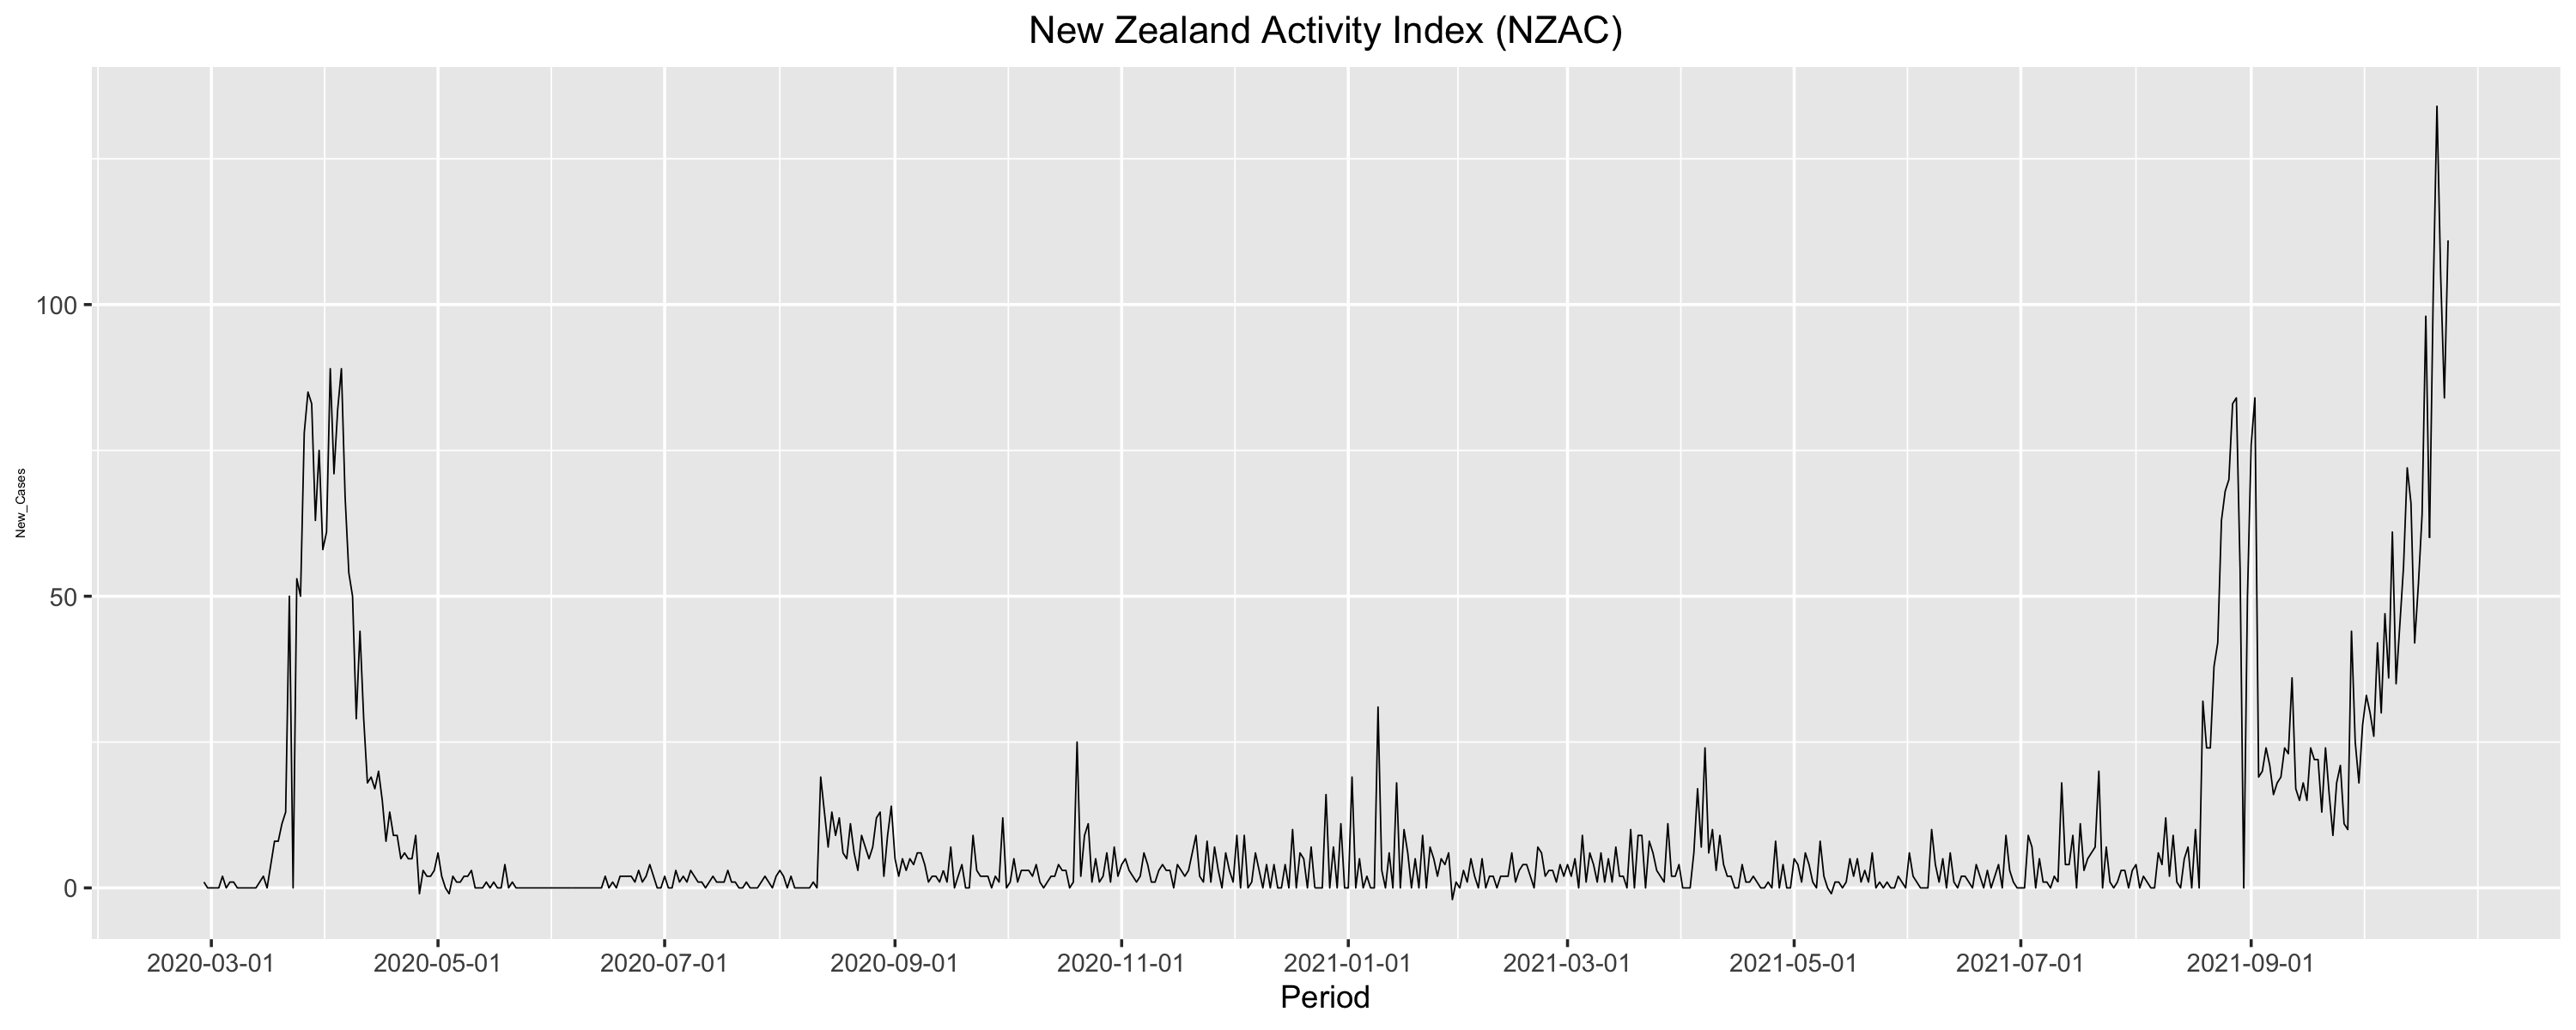

In [36]:
ggplot(data=NZ_Cases, aes(x=Period, y=New_Cases))+
  geom_line()+
  scale_x_date(breaks = datebreaks) +
  labs(title = "New Zealand Activity Index (NZAC)")+
  theme(plot.title = element_text(hjust = 0.5),
          axis.title.y = element_text(size = 9))

# Transactions & Spend GRAPH

# RENT GRAPH

In [38]:
datebreaks <- seq(as.Date("2015-01-01"), as.Date("2021-09-30"), by = "4 month")

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


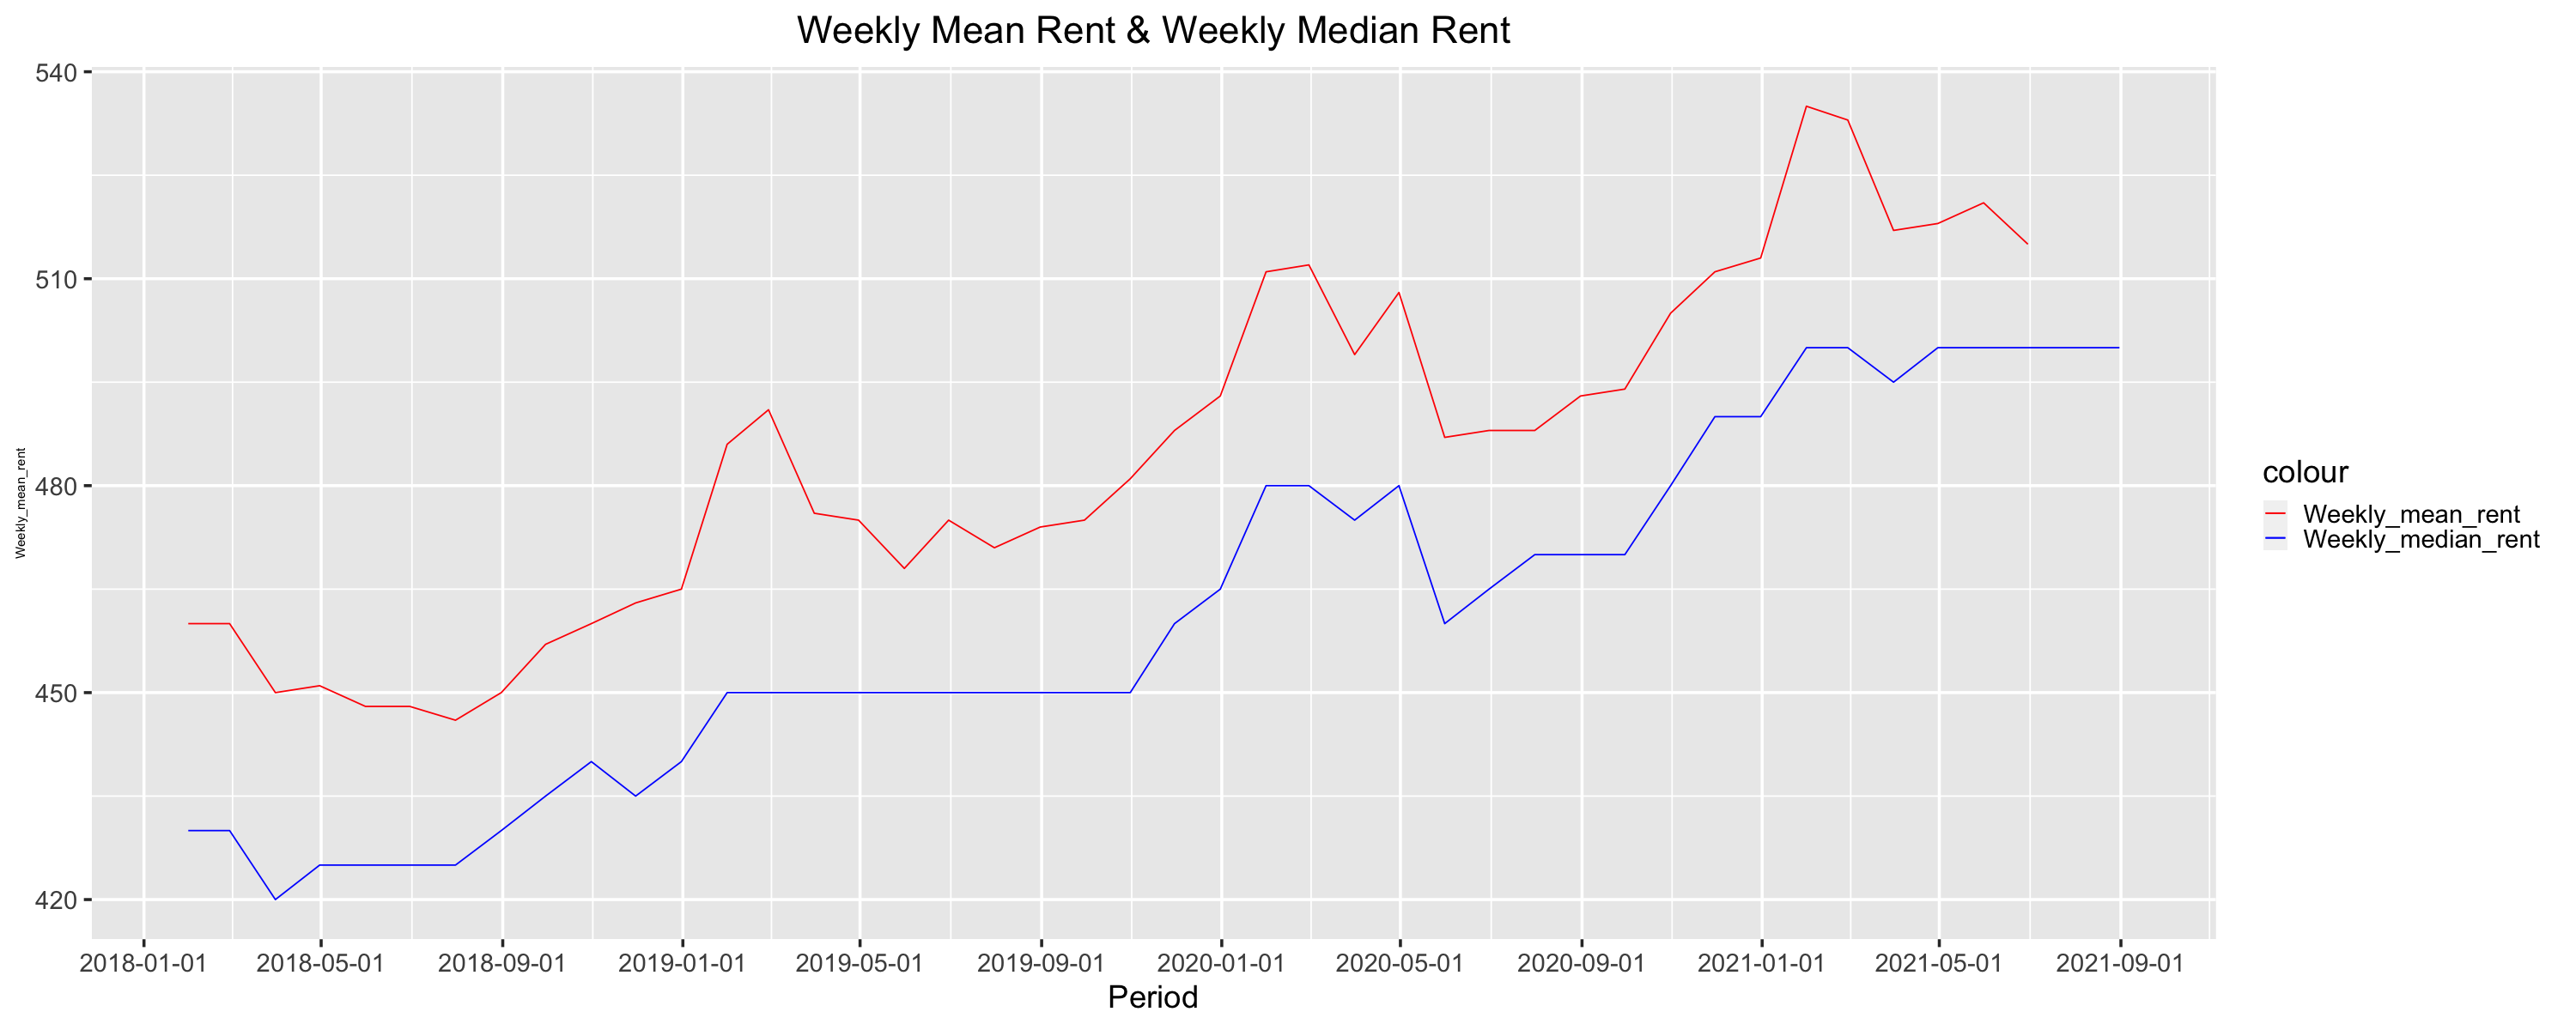

In [39]:
ggplot(data=final_table_2, aes(x=Period, y=Weekly_mean_rent))+
  geom_line(data=final_table_2,aes(x=Period, y=Weekly_mean_rent, color="Weekly_mean_rent"))+
  geom_line(data=final_table_2,aes(x=Period, y=Weekly_median_rent, color = "Weekly_median_rent"))+
  scale_color_manual(values = c("red","blue"))+
  scale_x_date(breaks = datebreaks) +
  labs(title = "Weekly Mean Rent & Weekly Median Rent")+
  theme(plot.title = element_text(hjust = 0.5),
          axis.title.y = element_text(size = 9))

# NZAC Graph

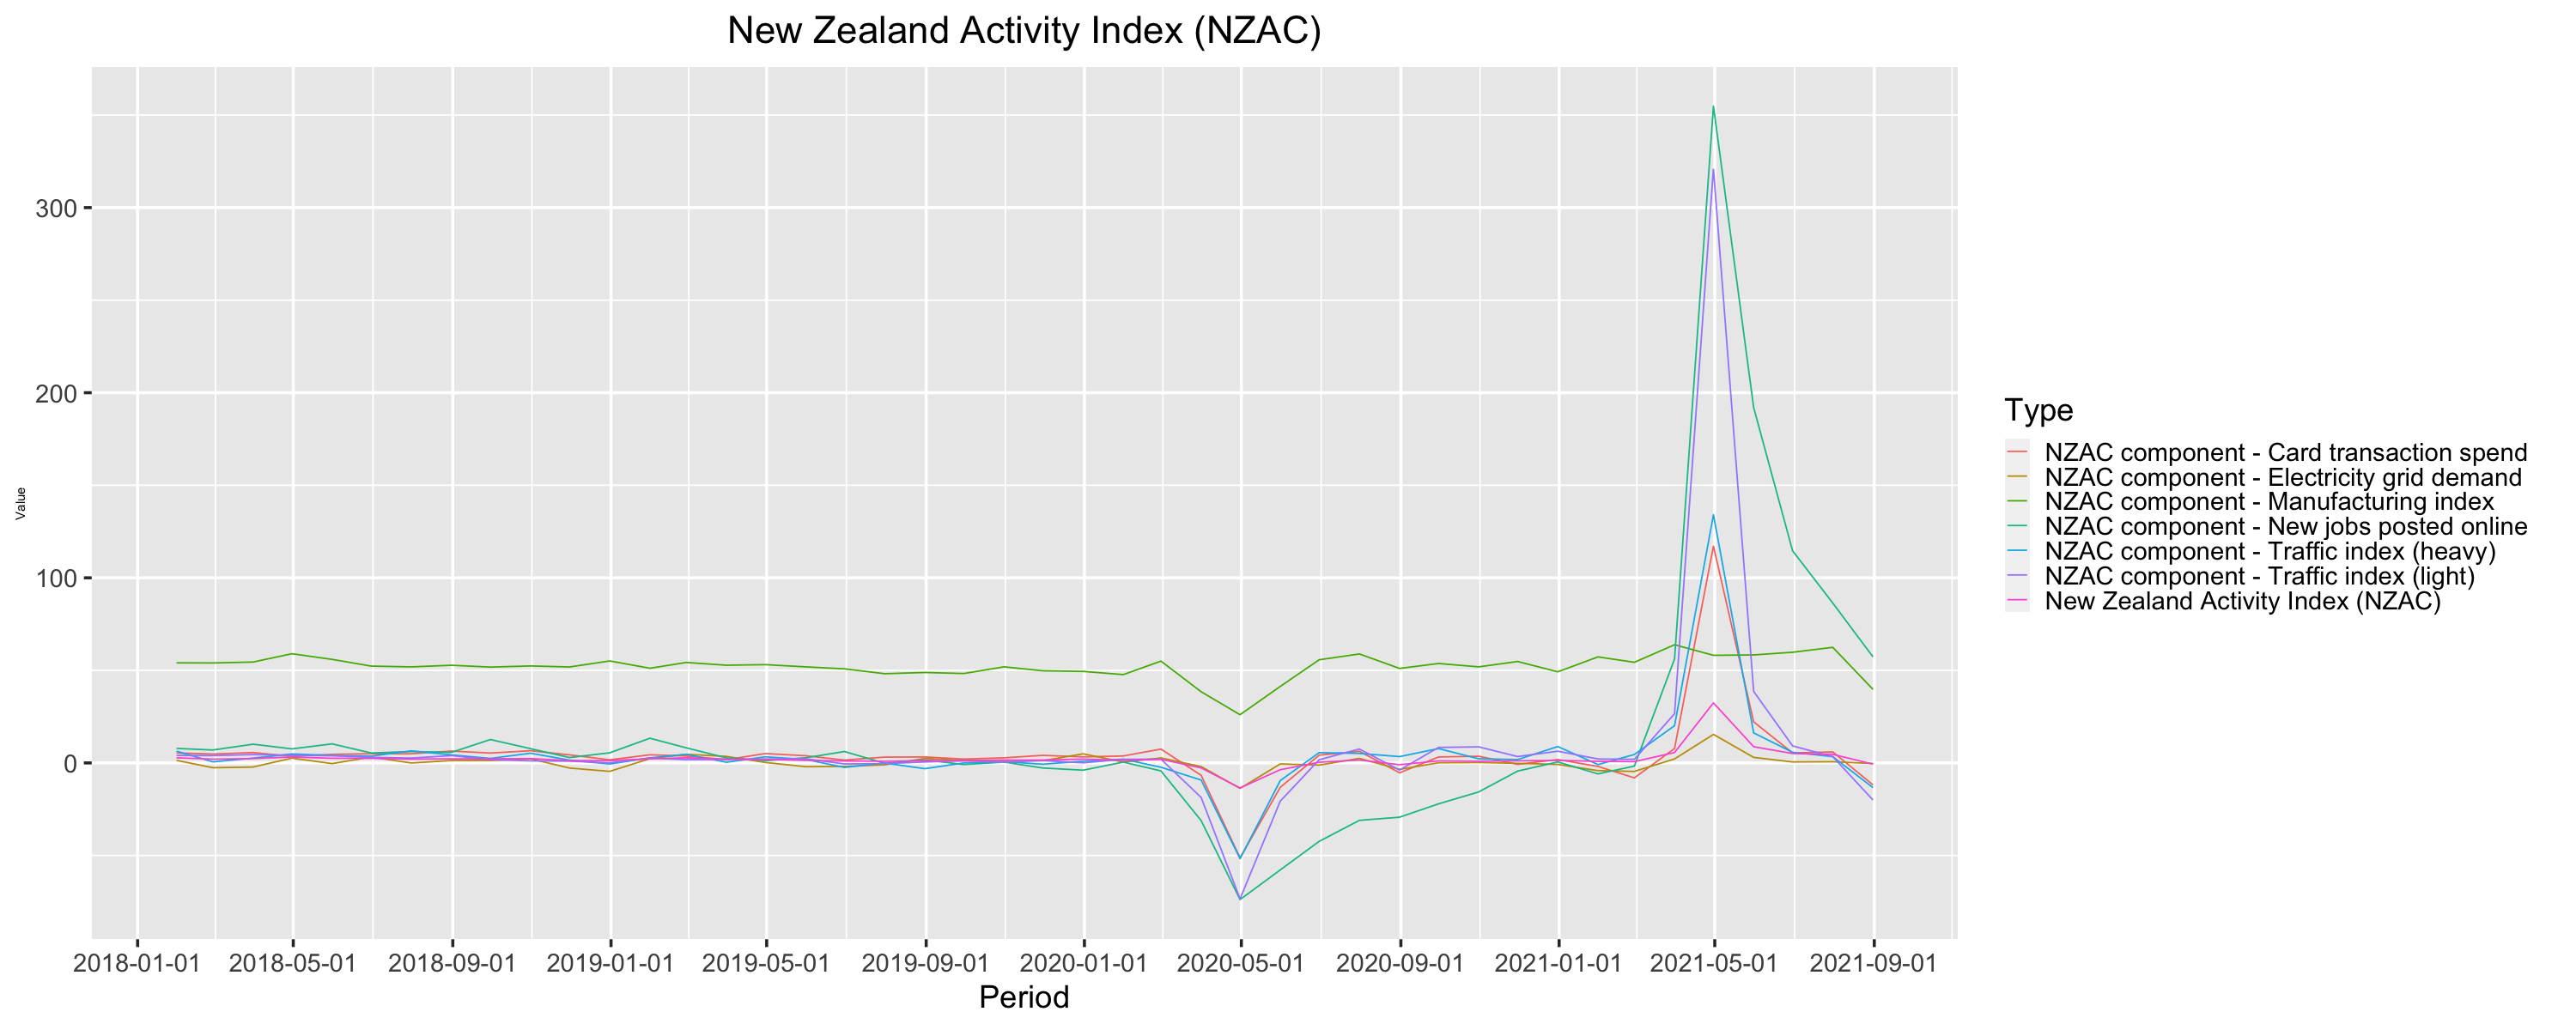

In [40]:
ggplot(data=NZAC, aes(x=Period, y=Value, group=Type, color=Type))+
  geom_line()+
  scale_x_date(breaks = datebreaks) +
  labs(title = "New Zealand Activity Index (NZAC)")+
  theme(plot.title = element_text(hjust = 0.5),
          axis.title.y = element_text(size = 9))

# 2021.4比起2020.4大幅上升

# CPI Graph

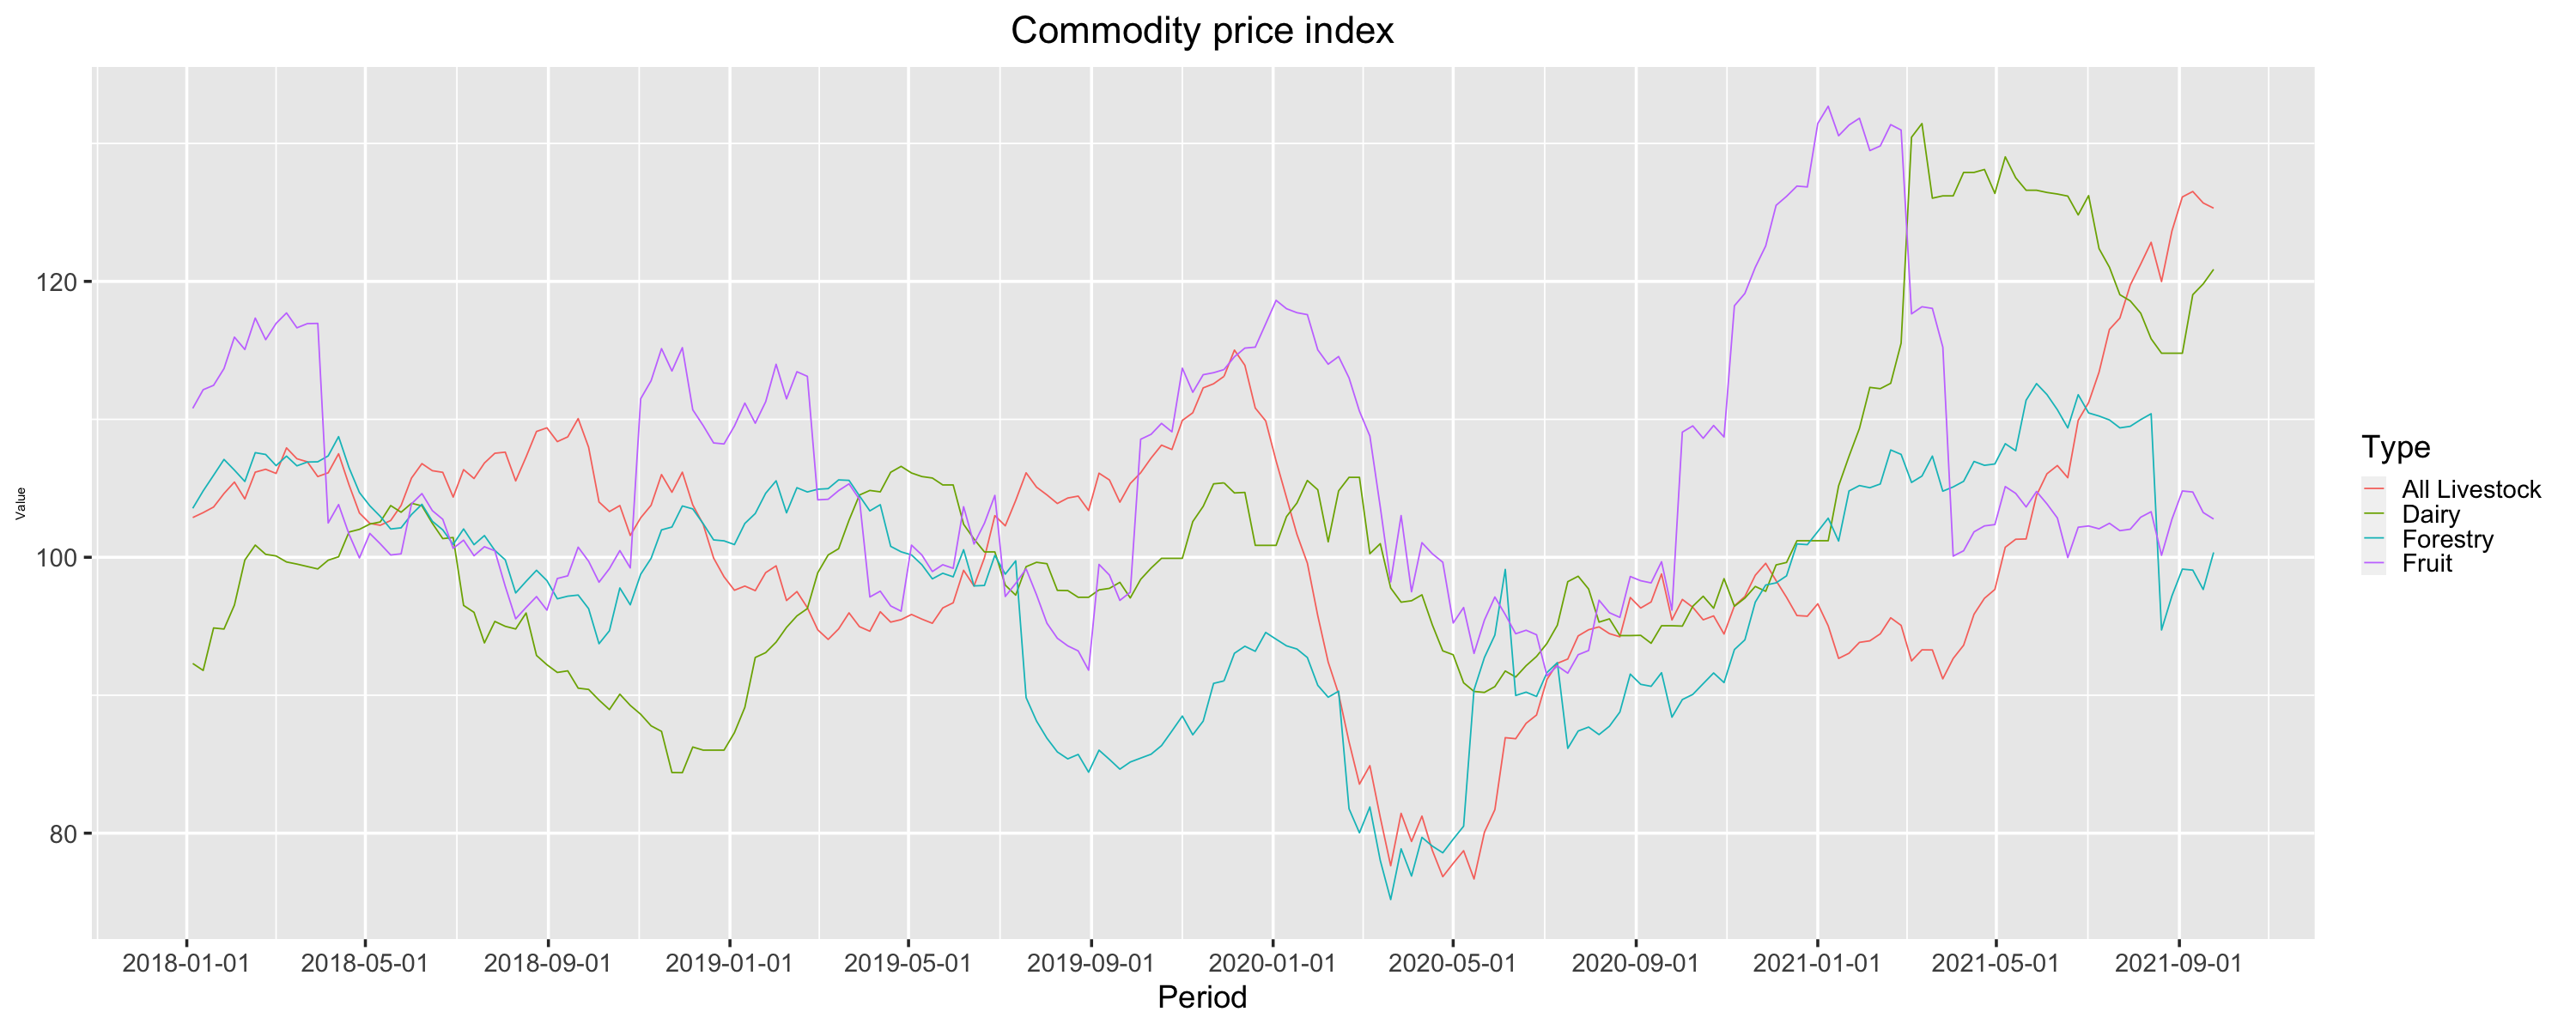

In [41]:
ggplot(data=cpi, aes(x=Period, y=Value, group=Type, color=Type))+
  geom_line()+
  scale_x_date(breaks = datebreaks) +
  labs(title = "Commodity price index")+
  theme(plot.title = element_text(hjust = 0.5),
          axis.title.y = element_text(size = 9))

ERROR while rich displaying an object: Error: At least one layer must contain all faceting variables: `Geo`.
* Plot is missing `Geo`
* Layer 1 is missing `Geo`
* Layer 2 is missing `Geo`

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

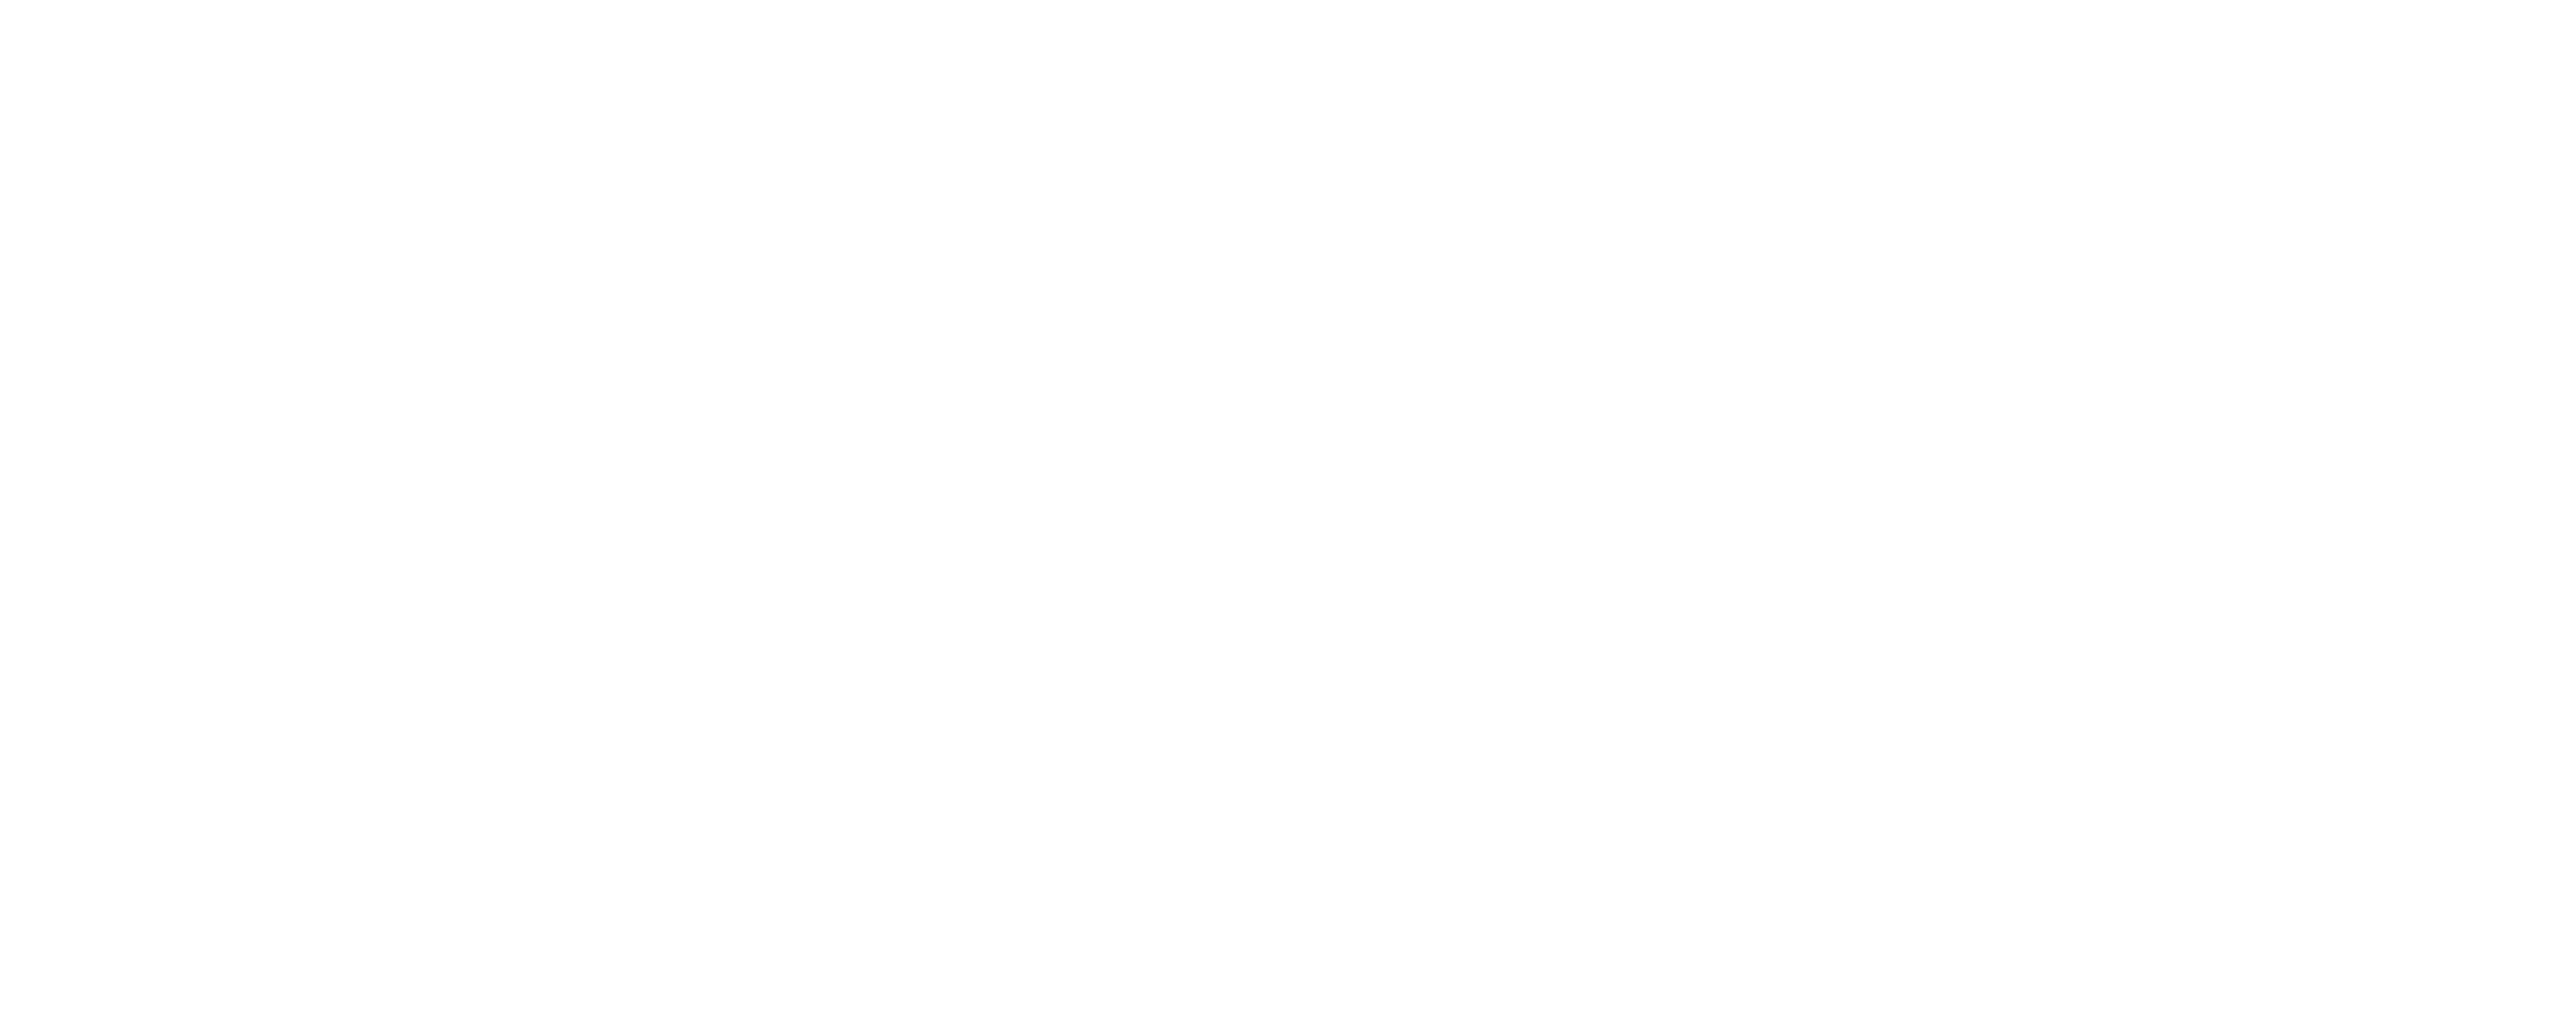

In [42]:

season_hour_bike <- Life_satis %>%
  ggplot( # we are using the ggplot2 library (it's been loaded together with tidyverse)
  mapping = # the mapping defines how the features of the data frame will be placed on the drawing area
      aes( # aes stands for aesthetics: this are the visual properties of the graph
      x = Period, # we want the hour on the x
      y = Value, # and the count of total rental bikes on the y
      group = Geo, # group the same hour together
      color = Label1)) + # add colour by season
  #geom_point() + # the geometry defines what sorts of "objects" to plot, in this case dots
  geom_boxplot(outlier.colour = "hotpink" ) + # the geometry defines boxes to plot
  geom_jitter(position = position_jitter(width=0.1, height =0 ), alpha =1/4)+  # the geometry defines jitter points to plot
  theme_minimal() + # themes are otherall stylistic features
  facet_wrap(~ Geo)# wraps a 1d sequence of panels into 2d

# Add title, and labels
season_hour_bike = season_hour_bike + 
  ggtitle("How the count of registered users rental bikes \n varies through time and season") +
  theme(plot.title = element_text(hjust=0.5,size = 16, face="bold")) + # change title format
  xlab("24 Hours") +
  ylab("The count of registered users rental bikes") +
  theme(axis.text.x = element_text(size=12), # change axis x and y format
        axis.text.y = element_text(size=12),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14))

season_hour_bike

# From the plot result, it is right.

In [45]:
install.packages('bit64')


The downloaded binary packages are in
	/var/folders/fg/rxqjnq854w76wx5d5ng790w40000gn/T//RtmpHuJhyn/downloaded_packages


In [ ]:
before_startday = as.Date("2019-1-1")
before_endday = as.Date("2020-2-28")

In [46]:
# get the trade csv file from the stats website
Trade_Data <- fread('https://www.stats.govt.nz/assets/Uploads/Effects-of-COVID-19-on-trade/Effects-of-COVID-19-on-trade-At-6-October-2021-provisional/Download-data/effects-of-covid-19-on-trade-at-6-october-2021-provisional.csv')
Trade_Data %>% glimpse() # a brief view of the content

Rows: 108,358
Columns: 10
$ Direction      <chr> "Exports", "Exports", "Exports", "Exports", "Exports", …
$ Year           <int> 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2…
$ Date           <chr> "01/01/2015", "02/01/2015", "03/01/2015", "04/01/2015",…
$ Weekday        <chr> "Thursday", "Friday", "Saturday", "Sunday", "Monday", "…
$ Country        <chr> "All", "All", "All", "All", "All", "All", "All", "All",…
$ Commodity      <chr> "All", "All", "All", "All", "All", "All", "All", "All",…
$ Transport_Mode <chr> "All", "All", "All", "All", "All", "All", "All", "All",…
$ Measure        <chr> "$", "$", "$", "$", "$", "$", "$", "$", "$", "$", "$", …
$ Value          <int> 104000000, 96000000, 61000000, 74000000, 105000000, 760…
$ Cumulative     <int64> 104000000, 200000000, 262000000, 336000000, 442000000…


In [72]:
exports <- Trade_Data %>% #Monthly spend compared to previous year
  filter(Country == "All", Commodity == "All", Transport_Mode == "All", Direction == "Exports") %>%
  select(Date, Measure, Value, Cumulative) %>%
  rename("Period" = Date, "Exports_Cumulative" = Cumulative)
exports$Period <- as.Date(exports$Period,"%d/%m/%Y")

In [73]:
imports <- Trade_Data %>% #Monthly spend compared to previous year
  filter(Country == "All", Commodity == "All", Transport_Mode == "All", Direction == "Imports") %>%
  select(Date, Value, Cumulative) %>%
  rename("Period" = Date, "Imports_Cumulative" = Cumulative)
imports$Period <- as.Date(imports$Period,"%d/%m/%Y")

In [74]:
exports<- exports[which(exports$Period >= startday & exports$Period < endday),]
imports <- imports[which(imports$Period >= startday & imports$Period < endday),]

In [75]:
final_daily <- full_join(
  exports,
  imports,
  by = "Period") %>%
  select(Period, "Measure", "Exports_Cumulative", "Imports_Cumulative")
final_daily

Period,Measure,Exports_Cumulative,Imports_Cumulative
<date>,<chr>,<int64>,<int64>
2018-01-01,$,65000000,69000000
2018-01-02,$,141000000,104000000
2018-01-03,$,230000000,311000000
2018-01-04,$,322000000,532000000
2018-01-05,$,427000000,774000000
2018-01-06,$,517000000,802000000
2018-01-07,$,651000000,831000000
2018-01-08,$,830000000,1132000000
2018-01-09,$,878000000,1349000000


In [ ]:
write.csv(final_daily, 'daily_trade_cases.csv')

In [ ]:
final_daily

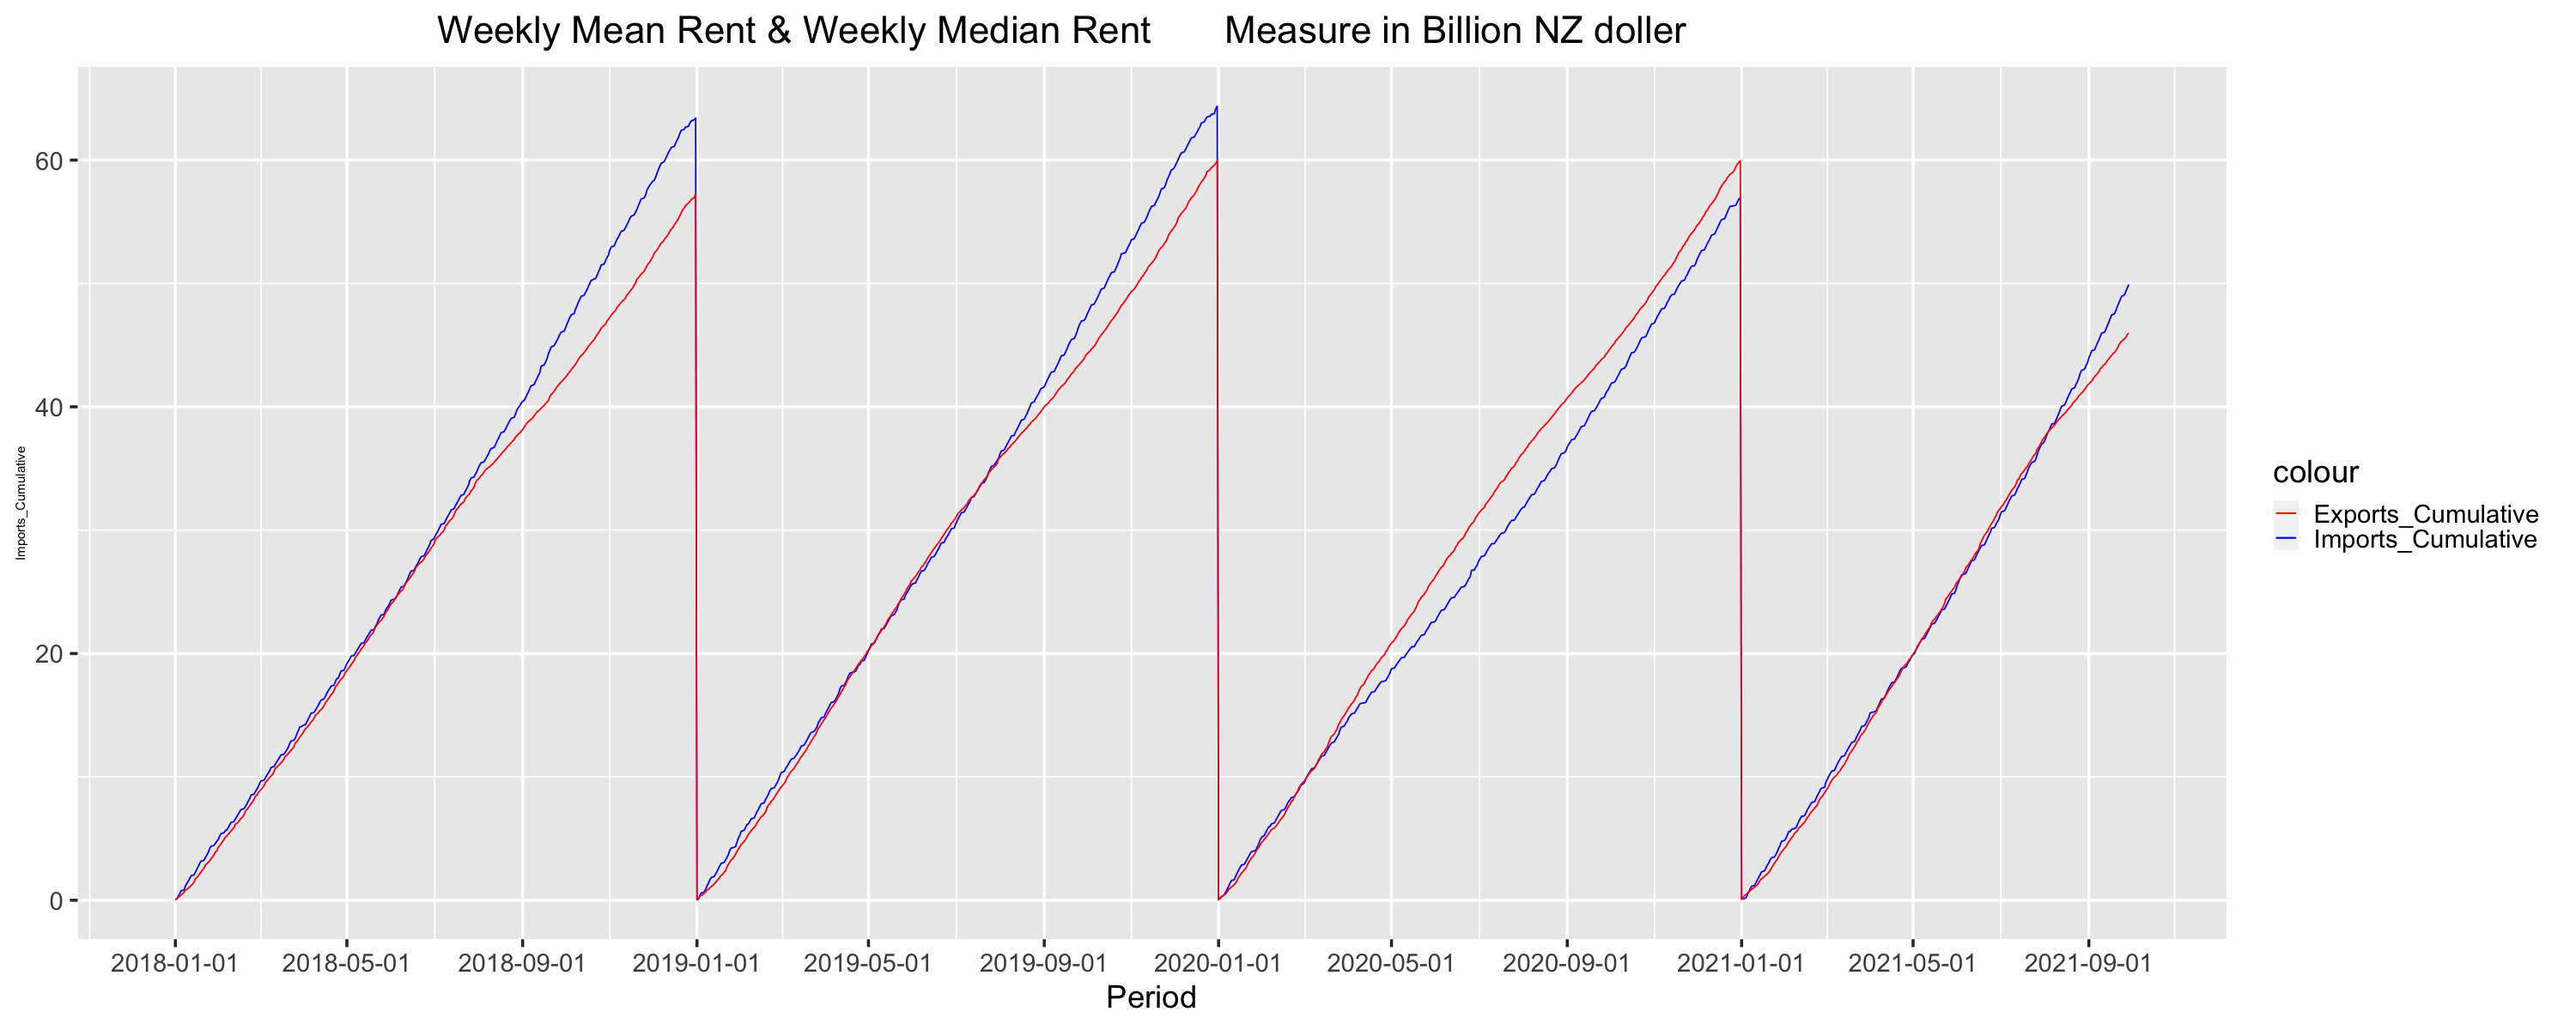

In [96]:
ggplot(data=final_daily, aes(x=Period, y=Imports_Cumulative))+
  geom_line(data=final_daily,aes(x=Period, y=Imports_Cumulative/1000000000, color="Imports_Cumulative"))+
  geom_line(data=final_daily,aes(x=Period, y=Exports_Cumulative/1000000000, color = "Exports_Cumulative"))+
  scale_color_manual(values = c("red","blue"))+
  scale_x_date(breaks = datebreaks) +
  labs(title = "Weekly Mean Rent & Weekly Median Rent       Measure in Billion NZ doller")+
  theme(plot.title = element_text(hjust = 0.4),
          axis.title.y = element_text(size = 9))

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)  #adjust the plots size
theme_set(theme_gray(base_size = 22)) # adjust the title, x-lab and y-lab sizes

daily_plot <- final_daily %>%
  ggplot( # we are using the ggplot2 library (it's been loaded together with tidyverse)
  mapping = # the mapping defines how the features of the data frame will be placed on the drawing area
      aes( # aes stands for aesthetics: this are the visual properties of the graph
      x = Date, # we want the hour on the x
      y = New_Cases))+# and the count of total rental bikes on the y
#       group = hr, # group the same hour together
#       color = season)) + # add colour by season
  geom_point() + # the geometry defines what sorts of "objects" to plot, in this case dots
  geom_boxplot(outlier.colour = "hotpink" ) + # the geometry defines boxes to plot
  geom_jitter(position = position_jitter(width=0.1, height =0 ), alpha =1/4)+  # the geometry defines jitter points to plot
  theme_minimal() + # themes are otherall stylistic features
  facet_wrap(~ season)# wraps a 1d sequence of panels into 2d

# Add title, and labels
daily_plot = daily_plot + 
  ggtitle("How the count of registered users rental bikes \n varies through time and season") +
  theme(plot.title = element_text(hjust=0.5,size = 16, face="bold")) + # change title format
  xlab("24 Hours") +
  ylab("The count of registered users rental bikes") +
  theme(axis.text.x = element_text(size=12), # change axis x and y format
        axis.text.y = element_text(size=12),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14))

season_hour_bike




In [ ]:
ggplot(final_daily, aes(x = Date))+
  geom_line(aes(y = New_Cases, color = "Case"))+
  geom_line(aes(y = Imports_Value/10000000, color = "Imports_Value"))+
  #~.*20表示次轴与主轴的关系是次轴=主轴乘以20
  #name表示次y轴的名称
  scale_y_continuous(sec.axis = sec_axis(~.*10000000, name = "New_Cases"))+
  scale_color_manual(values = c("red","blue"))+
  labs(title = "12")+
  theme(plot.title = element_text(hjust = 0.5),
          axis.title.y = element_text(size = 9))

In [ ]:
plot_2 <- ggplot(plot_2_df, mapping=aes(x = Age, y = Salary, color = Sport, alpha =1/5), show.legend = FALSE) + 
geom_point()  + coord_cartesian(xlim=c(18,43)) + guides(alpha = FALSE, color=guide_legend(title="Sports")) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs"), se=F) + 
xlab("Athlete's Age(From 18 to 43 Years Old)") + ylab("Total Salary($)") + ggtitle("Total Salary Vs Athlete's Age") + 
facet_grid(Sport~., scales="free_y") +
theme_grey(base_size = 22) + theme(plot.title = element_text(hjust=0.5), 
panel.background = element_rect(fill = "white", colour = "white",size = 0.5, linetype = "solid"), 
panel.grid.major = element_line(size = 0.5, linetype = 'solid',colour = "black"),
panel.grid.minor = element_line(size = 0.25, linetype = 'solid',colour = "black"),
strip.background = element_rect(color="black", fill="#E0E0E0", size=1, linetype="solid"))
require(scales) 
plot_2 + scale_y_continuous(labels = comma)